<a href="https://colab.research.google.com/github/xiaoya27/TensorFlow-Techniques-Notes/blob/main/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 47kB/s 
     |████████████████████████████████| 460kB 43.4MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras import initializers
import tensorflow.keras.backend as K


def _conv_layer(filters, kernel_size, strides=(1, 1), padding='same', name=None):
    return Conv2D(filters, kernel_size, strides=strides, padding=padding,
                  use_bias=True, kernel_initializer='he_normal', name=name)


def _normalize_depth_vars(depth_k, depth_v, filters):
    """
    Accepts depth_k and depth_v as either floats or integers
    and normalizes them to integers.
    Args:
        depth_k: float or int.
        depth_v: float or int.
        filters: number of output filters.
    Returns:
        depth_k, depth_v as integers.
    """

    if type(depth_k) == float:
        depth_k = int(filters * depth_k)
    else:
        depth_k = int(depth_k)

    if type(depth_v) == float:
        depth_v = int(filters * depth_v)
    else:
        depth_v = int(depth_v)

    return depth_k, depth_v


class AttentionAugmentation2D(Layer):

    def __init__(self, depth_k, depth_v, num_heads, relative=True, **kwargs):
        """
        Applies attention augmentation on a convolutional layer
        output.
        Args:
            depth_k: float or int. Number of filters for k.
            Computes the number of filters for `v`.
            If passed as float, computed as `filters * depth_k`.
        depth_v: float or int. Number of filters for v.
            Computes the number of filters for `k`.
            If passed as float, computed as `filters * depth_v`.
        num_heads: int. Number of attention heads.
            Must be set such that `depth_k // num_heads` is > 0.
        relative: bool, whether to use relative encodings.
        Raises:
            ValueError: if depth_v or depth_k is not divisible by
                num_heads.
        Returns:
            Output tensor of shape
            -   [Batch, Height, Width, Depth_V] if
                channels_last data format.
            -   [Batch, Depth_V, Height, Width] if
                channels_first data format.
        """
        super(AttentionAugmentation2D, self).__init__(**kwargs)

        if depth_k % num_heads != 0:
            raise ValueError('`depth_k` (%d) is not divisible by `num_heads` (%d)' % (
                depth_k, num_heads))

        if depth_v % num_heads != 0:
            raise ValueError('`depth_v` (%d) is not divisible by `num_heads` (%d)' % (
                depth_v, num_heads))

        if depth_k // num_heads < 1.:
            raise ValueError('depth_k / num_heads cannot be less than 1 ! '
                             'Given depth_k = %d, num_heads = %d' % (
                             depth_k, num_heads))

        if depth_v // num_heads < 1.:
            raise ValueError('depth_v / num_heads cannot be less than 1 ! '
                             'Given depth_v = %d, num_heads = %d' % (
                                 depth_v, num_heads))

        self.depth_k = depth_k
        self.depth_v = depth_v
        self.num_heads = num_heads
        self.relative = relative

        self.axis = 1 if K.image_data_format() == 'channels_first' else -1

    def build(self, input_shape):
        self._shape = input_shape

        # normalize the format of depth_v and depth_k
        self.depth_k, self.depth_v = _normalize_depth_vars(self.depth_k, self.depth_v,
                                                           input_shape)

        if self.axis == 1:
            _, channels, height, width = input_shape
        else:
            _, height, width, channels = input_shape

        if self.relative:
            dk_per_head = self.depth_k // self.num_heads

            if dk_per_head == 0:
                print('dk per head', dk_per_head)

            self.key_relative_w = self.add_weight('key_rel_w',
                                                  shape=[2 * width - 1, dk_per_head],
                                                  initializer=initializers.RandomNormal(
                                                      stddev=dk_per_head ** -0.5))

            self.key_relative_h = self.add_weight('key_rel_h',
                                                  shape=[2 * height - 1, dk_per_head],
                                                  initializer=initializers.RandomNormal(
                                                      stddev=dk_per_head ** -0.5))

        else:
            self.key_relative_w = None
            self.key_relative_h = None

    def call(self, inputs, **kwargs):
        if self.axis == 1:
            # If channels first, force it to be channels last for these ops
            inputs = K.permute_dimensions(inputs, [0, 2, 3, 1])

        q, k, v = tf.split(inputs, [self.depth_k, self.depth_k, self.depth_v], axis=-1)

        q = self.split_heads_2d(q)
        k = self.split_heads_2d(k)
        v = self.split_heads_2d(v)

        # scale query
        depth_k_heads = self.depth_k / self.num_heads
        q *= (depth_k_heads ** -0.5)

        # [Batch, num_heads, height * width, depth_k or depth_v] if axis == -1
        qk_shape = [self._batch, self.num_heads, self._height * self._width, self.depth_k // self.num_heads]
        v_shape = [self._batch, self.num_heads, self._height * self._width, self.depth_v // self.num_heads]
        flat_q = K.reshape(q, K.stack(qk_shape))
        flat_k = K.reshape(k, K.stack(qk_shape))
        flat_v = K.reshape(v, K.stack(v_shape))

        # [Batch, num_heads, HW, HW]
        logits = tf.matmul(flat_q, flat_k, transpose_b=True)

        # Apply relative encodings
        if self.relative:
            h_rel_logits, w_rel_logits = self.relative_logits(q)
            logits += h_rel_logits
            logits += w_rel_logits

        weights = K.softmax(logits, axis=-1)
        attn_out = tf.matmul(weights, flat_v)

        attn_out_shape = [self._batch, self.num_heads, self._height, self._width, self.depth_v // self.num_heads]
        attn_out_shape = K.stack(attn_out_shape)
        attn_out = K.reshape(attn_out, attn_out_shape)
        attn_out = self.combine_heads_2d(attn_out)
        # [batch, height, width, depth_v]

        if self.axis == 1:
            # return to [batch, depth_v, height, width] for channels first
            attn_out = K.permute_dimensions(attn_out, [0, 3, 1, 2])

        attn_out.set_shape(self.compute_output_shape(self._shape))

        return attn_out

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[self.axis] = self.depth_v
        return tuple(output_shape)

    def split_heads_2d(self, ip):
        tensor_shape = K.shape(ip)

        # batch, height, width, channels for axis = -1
        tensor_shape = [tensor_shape[i] for i in range(len(self._shape))]

        batch = tensor_shape[0]
        height = tensor_shape[1]
        width = tensor_shape[2]
        channels = tensor_shape[3]

        # Save the spatial tensor dimensions
        self._batch = batch
        self._height = height
        self._width = width

        ret_shape = K.stack([batch, height, width,  self.num_heads, channels // self.num_heads])
        split = K.reshape(ip, ret_shape)
        transpose_axes = (0, 3, 1, 2, 4)
        split = K.permute_dimensions(split, transpose_axes)

        return split

    def relative_logits(self, q):
        shape = K.shape(q)
        # [batch, num_heads, H, W, depth_v]
        shape = [shape[i] for i in range(5)]

        height = shape[2]
        width = shape[3]

        rel_logits_w = self.relative_logits_1d(q, self.key_relative_w, height, width,
                                               transpose_mask=[0, 1, 2, 4, 3, 5])

        rel_logits_h = self.relative_logits_1d(
            K.permute_dimensions(q, [0, 1, 3, 2, 4]),
            self.key_relative_h, width, height,
            transpose_mask=[0, 1, 4, 2, 5, 3])

        return rel_logits_h, rel_logits_w

    def relative_logits_1d(self, q, rel_k, H, W, transpose_mask):
        rel_logits = tf.einsum('bhxyd,md->bhxym', q, rel_k)
        rel_logits = K.reshape(rel_logits, [-1, self.num_heads * H, W, 2 * W - 1])
        rel_logits = self.rel_to_abs(rel_logits)
        rel_logits = K.reshape(rel_logits, [-1, self.num_heads, H, W, W])
        rel_logits = K.expand_dims(rel_logits, axis=3)
        rel_logits = K.tile(rel_logits, [1, 1, 1, H, 1, 1])
        rel_logits = K.permute_dimensions(rel_logits, transpose_mask)
        rel_logits = K.reshape(rel_logits, [-1, self.num_heads, H * W, H * W])
        return rel_logits

    def rel_to_abs(self, x):
        shape = K.shape(x)
        shape = [shape[i] for i in range(3)]
        B, Nh, L, = shape
        col_pad = K.zeros(K.stack([B, Nh, L, 1]))
        x = K.concatenate([x, col_pad], axis=3)
        flat_x = K.reshape(x, [B, Nh, L * 2 * L])
        flat_pad = K.zeros(K.stack([B, Nh, L - 1]))
        flat_x_padded = K.concatenate([flat_x, flat_pad], axis=2)
        final_x = K.reshape(flat_x_padded, [B, Nh, L + 1, 2 * L - 1])
        final_x = final_x[:, :, :L, L - 1:]
        return final_x

    def combine_heads_2d(self, inputs):
        # [batch, num_heads, height, width, depth_v // num_heads]
        transposed = K.permute_dimensions(inputs, [0, 2, 3, 1, 4])
        # [batch, height, width, num_heads, depth_v // num_heads]
        shape = K.shape(transposed)
        shape = [shape[i] for i in range(5)]

        a, b = shape[-2:]
        ret_shape = K.stack(shape[:-2] + [a * b])
        # [batch, height, width, depth_v]
        return K.reshape(transposed, ret_shape)

    def get_config(self):
        config = {
            'depth_k': self.depth_k,
            'depth_v': self.depth_v,
            'num_heads': self.num_heads,
            'relative': self.relative,
        }
        base_config = super(AttentionAugmentation2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def augmented_conv2d(ip, filters, kernel_size=(3, 3), strides=(1, 1),
                     depth_k=0.2, depth_v=0.2, num_heads=8, relative_encodings=True):
    """
    Builds an Attention Augmented Convolution block.
    Args:
        ip: keras tensor.
        filters: number of output filters.
        kernel_size: convolution kernel size.
        strides: strides of the convolution.
        depth_k: float or int. Number of filters for k.
            Computes the number of filters for `v`.
            If passed as float, computed as `filters * depth_k`.
        depth_v: float or int. Number of filters for v.
            Computes the number of filters for `k`.
            If passed as float, computed as `filters * depth_v`.
        num_heads: int. Number of attention heads.
            Must be set such that `depth_k // num_heads` is > 0.
        relative_encodings: bool. Whether to use relative
            encodings or not.
    Returns:
        a keras tensor.
    """
    # input_shape = K.int_shape(ip)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    depth_k, depth_v = _normalize_depth_vars(depth_k, depth_v, filters)

    conv_out = _conv_layer(filters - depth_v, kernel_size, strides)(ip)

    # Augmented Attention Block
    qkv_conv = _conv_layer(2 * depth_k + depth_v, (1, 1), strides)(ip)
    attn_out = AttentionAugmentation2D(depth_k, depth_v, num_heads, relative_encodings)(qkv_conv)
    attn_out = _conv_layer(depth_v, kernel_size=(1, 1))(attn_out)

    output = concatenate([conv_out, attn_out], axis=channel_axis)
    output = BatchNormalization()(output)
    return output


In [2]:
%tensorflow_version 2.x
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.28.203.58:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.28.203.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.28.203.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [5]:
if __name__ == '__main__':
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model
    with tpu_strategy.scope(): 
      ip = Input(shape=(128, 128, 3))
      x = augmented_conv2d(ip, filters=5, kernel_size=(11, 11),
                          depth_k=0.4, depth_v=0.4,  # dk/v (0.2) * f_out (20) = 4
                          num_heads=2, relative_encodings=True)

      model = Model(ip, x)
      model.summary()

      # Check if attention builds properly
      x = tf.zeros((8, 128, 128, 3))
      y = model(x)
      print("Attention Augmented Conv out shape : ", y.shape)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 6)  24          input_2[0][0]                    
__________________________________________________________________________________________________
attention_augmentation2d_1 (Att (None, 128, 128, 2)  510         conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 3)  1092        input_2[0][0]                    
_______________________________________________________________________________________

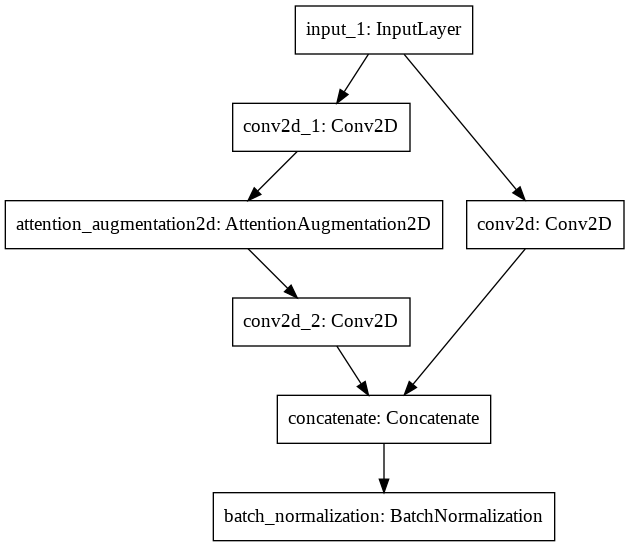

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(model)